In [1]:
#importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import datasets, metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

### Model 6:

Model will evaluate impact on Sale Price of:
- Overall Condition (feature engineering; log-transform based on skew)
- Overall Quality
- Interaction Condition and Quality (feature engineering)
- Bathrooms (feature engineering)
- Bedrooms
- Total sqft House (feature engineering; log-transform based on skew)
- Total sqft Lot Afea (feature engineering; log-transform based on skew) 

We see that SalePrice is not normally distributed, which means that it can either be log-transformed for our analysis, to better handle outliers, OR we can look at some individual variables in our model to see whether they have a logarithmic relationship with our dependent variable.

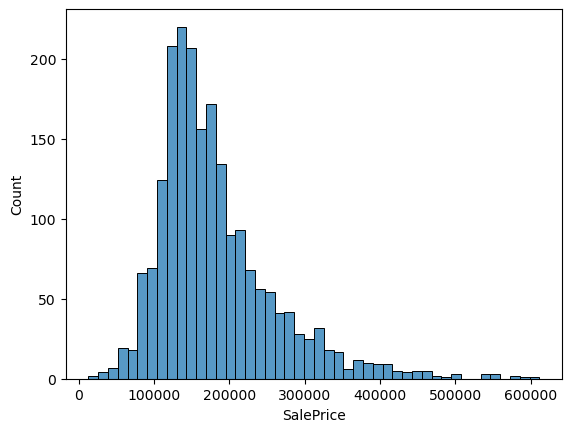

In [39]:
sns.histplot(df["SalePrice"]);

We can see that Sale Price is positively skewed. Applying logarithmic transformation will help normalize the dependent variable.

In [4]:
%store -r df_no_na
df_no_na["Transform_SalePrice"]=np.log10(df_no_na["SalePrice"])

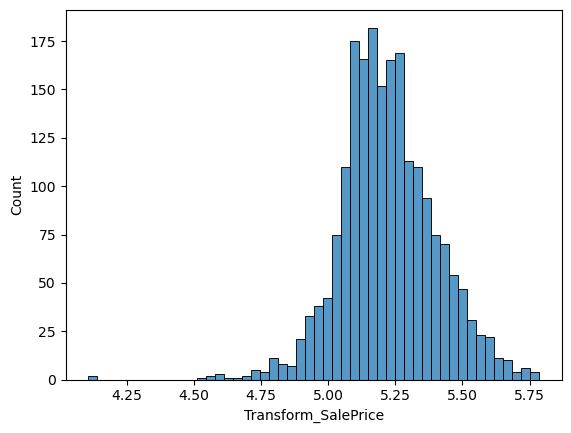

In [5]:
sns.histplot(df_no_na["Transform_SalePrice"]);

### Feature Engineering

**Total Sqft House** (Log-transformation)

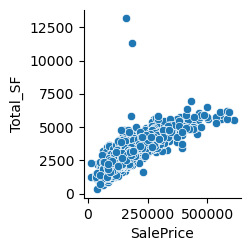

In [6]:
sns.pairplot(df_no_na, y_vars=['Total_SF'], x_vars=['SalePrice']);

**Note:** 
- There are outliers in our Total Sqft House variable, and (later we'll see that the distribution for this variable is skewed). We can see that there is a decrease in impact from sqft as Sale Price increases. 

We will also remove some outliers, since these are not being smoothed out by transformation.

In [827]:
df_no_na_new = df_no_na.loc[(df_no_na["Lot Area"] <= 100000) & (df_no_na["Total_SF"] <= 7500) & (df_no_na["Transform_SalePrice"] >= 4.5)]
#remove outlier houses where Lot Area is > 100000sqft
#remove outlier houses where Total SF is > 7500sqft
#remove outlier houses with transformed sale price < 4.5

In [849]:
#repeat for test data

df_test_no_na_new = df_test_no_na.loc[(df_test_no_na["Lot Area"] <= 100000) & (df_test_no_na["Total_SF"] <= 7500)]
#remove outlier houses where Lot Area is > 100000sqft
#remove outlier houses where Total SF is > 7500sqft

In [7]:
df_no_na["Transform_SF"] = np.log10(df_no_na["Total_SF"])

In [11]:
#repeat for test data
%store -r df_test_no_na
df_test_no_na["Total_SF"] = df_test_no_na[["Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Garage Area"]].sum(axis=1) 
df_test_no_na["Transform_SF"] = np.log10(df_test_no_na["Total_SF"])

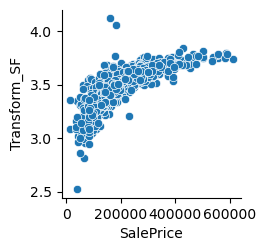

In [12]:
sns.pairplot(df_no_na, y_vars=['Transform_SF'], x_vars=['SalePrice']);

**Bathrooms (from Model 5)**

In [16]:
df_no_na["Bathrooms"] = df_no_na["Full Bath"] + df_no_na["Bsmt Half Bath"] + df_no_na["Bsmt Full Bath"] + df_no_na["Half Bath"]

In [17]:
df_test_no_na["Bathrooms"] = df_test_no_na["Full Bath"] + df_test_no_na["Bsmt Half Bath"] + df_test_no_na["Bsmt Full Bath"] + df_test_no_na["Half Bath"]

<br>

**Interaction of Quality/Condition (from Models 2 and 3)**

In [19]:
df_no_na["Qual_cond"] = df_no_na["Overall Qual"] * df_no_na["Overall Cond"]

In [20]:
df_test_no_na["Qual_cond"] = df_test_no_na["Overall Qual"] * df_test_no_na["Overall Cond"]

**Correlation Matrix**

In [22]:
df_no_na_new_analysis = df_no_na[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Lot Area",
                         "SalePrice"]]

In [24]:
#repeat for test data
df_test_no_na_new_analysis = df_test_no_na[["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Lot Area",]]

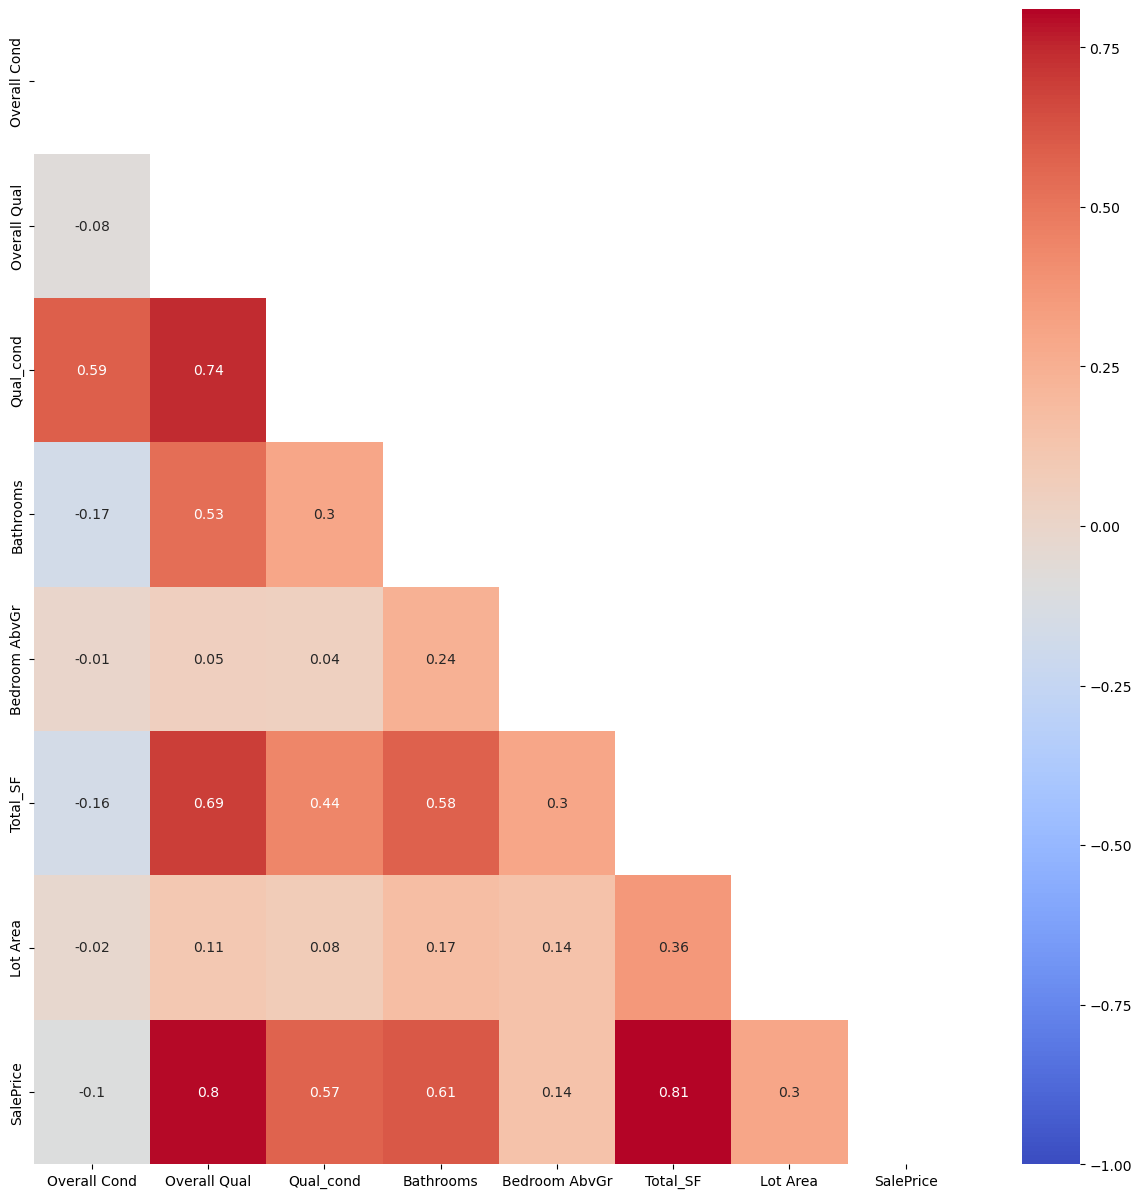

In [23]:
fig, ax = plt.subplots(figsize = (15,15))
mask = np.triu(np.ones_like(df_no_na_new_analysis.corr(), dtype=bool))
sns.heatmap(round(df_no_na_new_analysis.corr(),2), annot=True, mask = mask, cmap="coolwarm", vmin=-1);

**Note:**
- Looks like the Overall Condition does not have a strong relationship with Sale Price
- Quality and Total Sqft continue to be front and center (but have moderate multicollinearity with other independent variables)

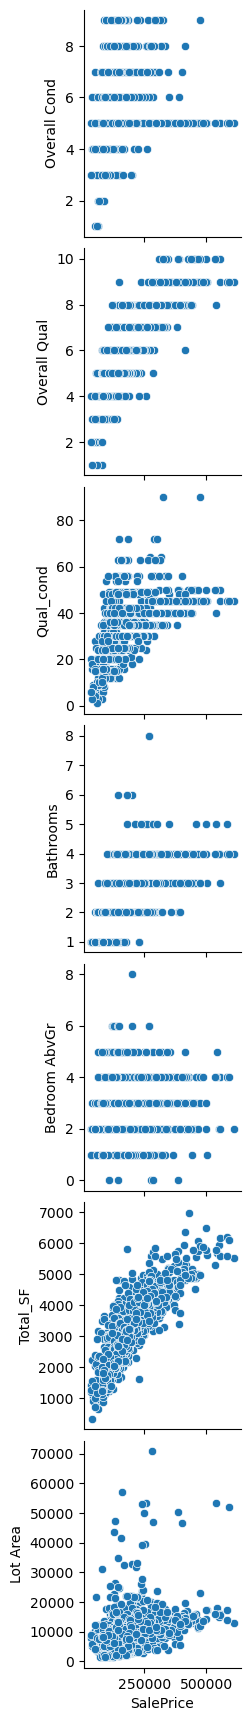

In [831]:
sns.pairplot(df_no_na_new_analysis, y_vars=["Overall Cond", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Total_SF",
                        "Lot Area",], x_vars=['SalePrice']);

**Independent variables with a skew of greater than 0.5 are log-transformed**

In [830]:

for col in df_no_na_new_analysis:
    if df_no_na_new_analysis[col].skew() >= 0.5 or df_no_na_new_analysis[col].skew() <= -0.5:
        np.log10(df_no_na_new_analysis[col])

In [832]:
df_no_na_new_analysis.skew()

Overall Cond     0.655226
Overall Qual     0.165027
Qual_cond        0.252908
Bathrooms        0.467561
Bedroom AbvGr    0.368094
Total_SF         0.635956
Lot Area         3.950346
SalePrice        1.574301
dtype: float64

In [25]:
df_no_na_new_analysis["Transform_Lot_Area"] = np.log10(df_no_na_new_analysis["Lot Area"])
df_no_na_new_analysis["Transform_Total_SF"] = np.log10(df_no_na_new_analysis["Total_SF"])
df_no_na_new_analysis["Transform_Condition"] = np.log10(df_no_na_new_analysis["Overall Cond"])

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/1814481200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_new_analysis["Transform_Lot_Area"] = np.log10(df_no_na_new_analysis["Lot Area"])
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/1814481200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_new_analysis["Transform_Total_SF"] = np.log10(df_no_na_new_analysis["Total_SF"])
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/1814481200.

In [26]:
#repeat for test data
df_test_no_na_new_analysis["Transform_Lot_Area"] = np.log10(df_test_no_na_new_analysis["Lot Area"])
df_test_no_na_new_analysis["Transform_Total_SF"] = np.log10(df_test_no_na_new_analysis["Total_SF"])
df_test_no_na_new_analysis["Transform_Condition"] = np.log10(df_test_no_na_new_analysis["Overall Cond"])

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/2432116610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_new_analysis["Transform_Lot_Area"] = np.log10(df_test_no_na_new_analysis["Lot Area"])
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/2432116610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_new_analysis["Transform_Total_SF"] = np.log10(df_test_no_na_new_analysis["Total_SF"])
/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykern

**NAs are removed post transformation**

In [27]:
df_no_na_new_analysis.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/1572203892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na_new_analysis.dropna(how = "any", inplace = True)


In [28]:
#repeat for test data
df_test_no_na_new_analysis.dropna(how = "any", inplace = True)

/var/folders/r7/lck4_m6n3qvgvrpymc_hdq900000gn/T/ipykernel_38501/2527835327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_no_na_new_analysis.dropna(how = "any", inplace = True)


### Model - Lasso Regression

In [31]:
X6 = df_no_na_new_analysis[["Transform_Condition", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Transform_Total_SF",
                        "Transform_Lot_Area",]]
y6 = df_no_na_new_analysis["SalePrice"]

In [30]:
X6_for_test = df_test_no_na_new_analysis[["Transform_Condition", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Transform_Total_SF",
                        "Transform_Lot_Area",]]

In [32]:
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, random_state=42)

In [33]:
ss = StandardScaler()
#ss.fit(X_train)
X6_train = ss.fit_transform(X6_train)
X6_test = ss.transform(X6_test)

In [34]:
lasso_6 = Lasso(alpha=1)
lasso_6.fit(X6_train, y6_train)

Lasso(alpha=1)

In [38]:
print('R2 training data', round(lasso_6.score(X6_train, y6_train), 2))
print('R2 test data', round(lasso_6.score(X6_test, y6_test), 2))

R2 training data 0.77
R2 test data 0.8


In [39]:
pred_train6 = lasso_6.predict(X6_train)
mse_train6 = mean_squared_error(y6_train, pred_train6)
print('RMSE training data', round(mse_train6**0.5, 2))

# Test data
pred6 = lasso_6.predict(X6_test)
mse_test6 = mean_squared_error(y6_test, pred6)
print('RMSE test data', round(mse_test6**0.5, 2))

RMSE training data 37931.91
RMSE test data 34404.71


In [40]:
from sklearn.linear_model import LassoCV
model_lasso_6 = LassoCV(cv=5, random_state=0, max_iter=10000)
model_lasso_6.fit(X6_train, y6_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [41]:
#best penalty term for Lasso
model_lasso_6.alpha_

157.93776531782518

In [42]:
lasso_6_best = Lasso(alpha=model_lasso_6.alpha_)
lasso_6_best.fit(X6_train, y6_train)

Lasso(alpha=157.93776531782518)

In [43]:
print('R2 training data', round(lasso_6_best.score(X6_train, y6_train), 2))
print('R2 test data', round(lasso_6_best.score(X6_test, y6_test), 2))
pred_train6_best = lasso_6_best.predict(X6_train)
mse_train6_best = mean_squared_error(y6_train, pred_train6_best)
print('RMSE training data', round(mse_train6_best**0.5, 2))

# Test data
pred6_best = lasso_6_best.predict(X6_test)
mse_test6_best = mean_squared_error(y6_test, pred6_best)
print('RMSE test data', round(mse_test6_best**0.5, 2))

R2 training data 0.77
R2 test data 0.8
RMSE training data 37935.0
RMSE test data 34434.54


In [44]:
X_6_test_pred = X6_for_test.values

In [860]:
submission6 = pd.DataFrame(df_test, columns=["Id"])
submission6["SalePrice"] = lasso_6_best.predict(X_6_test_pred)

In [861]:
submission6.to_csv('../datasets/submission6.csv', index=False)

### Model Validation

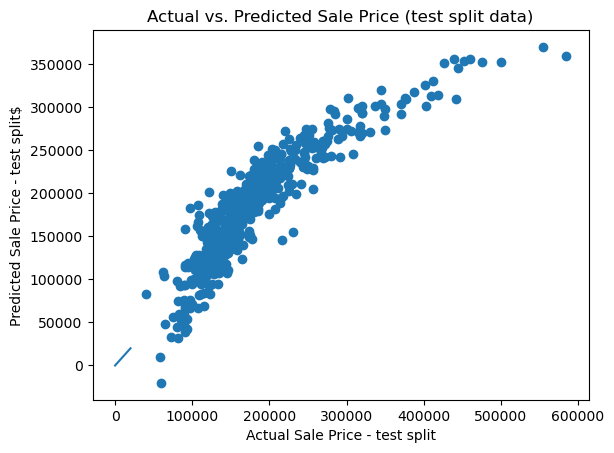

In [45]:
plt.scatter(y6_test, pred6_best)
plt.plot(range(20000), range(20000))

plt.xlabel("Actual Sale Price - test split")
plt.ylabel("Predicted Sale Price - test split$")
plt.title("Actual vs. Predicted Sale Price (test split data)")

plt.show()

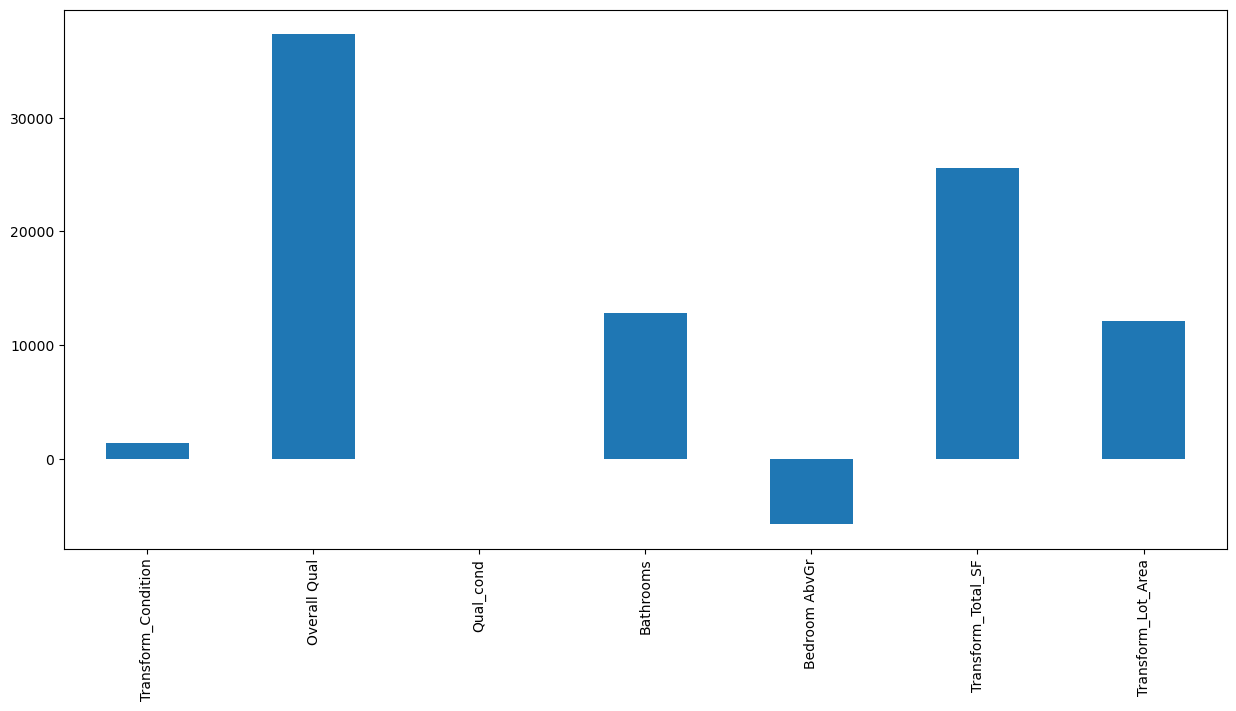

In [46]:
pd.Series(lasso_6_best.coef_, index=("Transform_Condition", 
                         "Overall Qual", 
                         "Qual_cond", 
                         "Bathrooms", 
                         "Bedroom AbvGr", 
                         "Transform_Total_SF",
                        "Transform_Lot_Area")).plot.bar(figsize = (15, 7));

**Note:** 
- Based on the Lasso Regularization, we can consider removing the Transform Condition variable and/or the interaction term between Condition and Quality.